In [45]:
import pandas as pd
import numpy as np

In [46]:
df=pd.read_csv('data.csv',encoding="latin1")

/tmp/ipython-input-1029817289.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('data.csv',encoding="latin1")


In [47]:
df.shape

(435742, 13)

In [48]:
df.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [49]:
df['no2'].isnull().sum()


np.int64(16233)

In [50]:
x=df['no2'].dropna().values

In [51]:
r=120317145
a_r=0.5*(r%7)
b_r=0.3*(r%5+1)
print("a_r =", a_r)
print("b_r =", b_r)

a_r = 2.0
b_r = 0.3


**Step 1:Transformation**

In [52]:
z = x+a_r * np.sin(b_r * x)

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim

In [54]:
z_tensor = torch.tensor(z, dtype=torch.float32).view(-1, 1)


In [61]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)
#The generator inputs random nois and outputs fake z values.

In [56]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)
#the discriminator outputs probability of whether
#the input to it(the output of generator) is fake or real.

In [57]:
G = Generator()
D = Discriminator()
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.001)
optimizer_D = optim.Adam(D.parameters(), lr=0.001)

**Step 2:Training the GAN(Core part)**

In [58]:
epochs = 3000
batch_size = 64

for epoch in range(epochs):

    idx = np.random.randint(0, len(z_tensor), batch_size)
    real_samples = z_tensor[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)

    D_real = D(real_samples)
    D_fake = D(fake_samples.detach())

    loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

#training the generator

    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)
    D_fake = D(fake_samples)

    loss_G = criterion(D_fake, real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")


Epoch 0 | D Loss: 1.3635 | G Loss: 0.7103
Epoch 500 | D Loss: 1.3349 | G Loss: 0.9742
Epoch 1000 | D Loss: 1.4971 | G Loss: 0.5962
Epoch 1500 | D Loss: 1.3998 | G Loss: 0.7388
Epoch 2000 | D Loss: 1.4006 | G Loss: 0.7452
Epoch 2500 | D Loss: 1.3917 | G Loss: 0.6715


In [59]:
#Generating samples from Generator
noise = torch.randn(10000, 1)
z_fake = G(noise).detach().numpy()


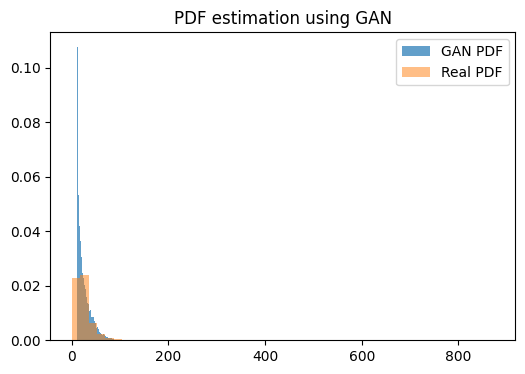

In [60]:
plt.figure(figsize=(6,4))
plt.hist(z_fake, bins=50, density=True, alpha=0.7, label="GAN PDF")
plt.hist(z, bins=50, density=True, alpha=0.5, label="Real PDF")
plt.legend()
plt.title("PDF estimation using GAN")
plt.show()
